# **Homework 3** Problem 2

In [1]:
%matplotlib inline

In [2]:
import json
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image


# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000)  # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Prepare CIFAR-50 Dataset

Download dataset to your Google Drive from https://drive.google.com/drive/folders/1WGUKBP5Eta9DAltK1WtvRbX43iwP08DU?usp=sharing (please use your UW account to get access).

Unzip the files.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [5]:
!mkdir -p ./data/cifar50
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/ee-596/hw-3/cifar50.zip -d ./data/cifar50

Streaming output truncated to the last 5000 lines.
  inflating: ./data/cifar50/images/sunflower/train_23323.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23431.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23457.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23464.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23507.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23533.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23624.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23707.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23713.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23801.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23814.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23830.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23874.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23902.jpg  
  inflating: ./data/cifar50/images/sunflower/train_23959.jpg  
  in

In [6]:
!mkdir -p ./data/cifar50_imbalance_0.02
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/ee-596/hw-3/cifar50_imbalance.zip -d ./data/cifar50_imbalance_0.02

Streaming output truncated to the last 5000 lines.
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4763.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4764.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4765.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4766.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4767.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4768.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4769.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4770.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4771.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4772.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4773.jpg  
  inflating: ./data/cifar50_imbalance_0.02/images/flatfish/train_4774.jpg  
  inflating: ./data/cifar50_imbalance

Load and print label files to know the format of the provided labels.
- `cifar50_train.json`
- `cifar50_imbalance_0.02_train.json`

## Load JSON files and print.

Print CIFAR50 - For this set I only print a few samples because when I changes some of the output settings my browser would occassionally freeze.

In [7]:
f = open('data/cifar50/cifar50_train.json',)
cifar_train_json = json.load(f)
f.close()
print(cifar_train_json['annotations'][0])
print(cifar_train_json['annotations'][1])
print(cifar_train_json['annotations'][2])

{'fpath': 'data\\cifar50\\images\\apple\\train_0.jpg', 'image_id': 0, 'category_id': 0, 'category': 'apple'}
{'fpath': 'data\\cifar50\\images\\telephone\\train_1.jpg', 'image_id': 1, 'category_id': 86, 'category': 'telephone'}
{'fpath': 'data\\cifar50\\images\\train\\train_2.jpg', 'image_id': 2, 'category_id': 90, 'category': 'train'}


Print CIFAR50 Imbalanced

In [8]:
f = open('data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json',)
cifar_imb_train_json = json.load(f)
f.close()
print(cifar_imb_train_json)

{'annotations': [{'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_0.jpg', 'image_id': 0, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_1.jpg', 'image_id': 1, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_2.jpg', 'image_id': 2, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_3.jpg', 'image_id': 3, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_4.jpg', 'image_id': 4, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_5.jpg', 'image_id': 5, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_6.jpg', 'image_id': 6, 'category_id': 0, 'category': 'apple'}, {'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_7.jpg', 'image_id': 7, 'category_id': 0, 'cate

## Create Data Loaders

In [9]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 42

# Number of channels in the training images. For color images this is 3
nc = 3

In [10]:
class CifarImages(Dataset):
    def __init__(self, images, trans):
      self.images = images
      self.transform = trans 
      
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]['fpath'].replace('\\', '/')
        label = int(self.images[idx]['category_id'] / 2)
        
        return self.transform(Image.open(image_path).convert("RGB")), label

In [31]:
cifar_classes = [None]*50
for i in cifar_train_json['annotations']:
  cifar_classes[int(i['category_id']/2)] = i['category']

In [15]:
from torch.utils.data import ConcatDataset

base_transforms = [
  T.ToTensor(),
  T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

cifar_train_set = CifarImages(cifar_train_json['annotations'], T.Compose(base_transforms))


# randomly flipped images
flipped_trans = base_transforms.copy() 
flipped_trans.insert(0, T.RandomHorizontalFlip())
cifar_flipped = CifarImages(cifar_train_json['annotations'], T.Compose(flipped_trans))


# randomly rotated images
rotated_trans = base_transforms.copy() 
rotated_trans.insert(0, T.RandomRotation((90,90)))
cifar_rotated = CifarImages(cifar_train_json['annotations'], T.Compose(rotated_trans))


# add noise
noise_trans = base_transforms.copy() 
noise_trans.insert(0, T.GaussianBlur(kernel_size=3))
cifar_noise = CifarImages(cifar_train_json['annotations'], T.Compose(noise_trans))


# randomly shift images up/down
shift_trans = base_transforms.copy() 
shift_trans.insert(0, T.RandomAffine(degrees=0, translate=(.1,.1)))
cifar_shift = CifarImages(cifar_train_json['annotations'], T.Compose(shift_trans))

full_trainset = ConcatDataset([cifar_train_set, cifar_flipped, cifar_rotated, cifar_noise, cifar_shift])

val_size = int(len(full_trainset)*.2)
train_size = int(len(full_trainset) - val_size)
train_ds, val_ds = random_split(full_trainset, [train_size, val_size])

cifar_train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
cifar_val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=workers, pin_memory=True)


In [37]:
f = open('data/cifar50/cifar50_test.json',)
cifar_test_json = json.load(f)
f.close()

cifar_test_set = CifarImages(cifar_test_json['annotations'], T.Compose(base_transforms))
cifar_test_loader = DataLoader(cifar_test_set, batch_size=batch_size, num_workers=workers, pin_memory=True)

Show some images with labels (class names) from dataset.

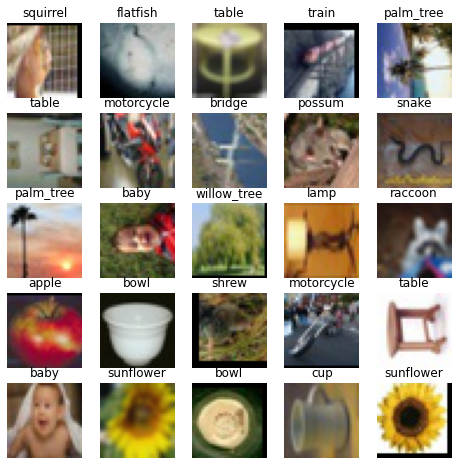

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def cifar_imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

images, labels = iter(cifar_train_loader).next()

fig, axs = plt.subplots(5, 5, figsize = (8, 8))
for i, ax in enumerate(axs.flat):
  ax.imshow(cifar_imshow(images[i]))
  ax.axis('off')
  ax.set_title('{}'.format(cifar_classes[labels[i]]))

## Train CNNs.

#### Use the CNN in HW2 to train the model on the balanced CIFAR50 dataset.

Train the CNN on the balanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 

Note: You can use any network configurations you implemented in HW2.

In [20]:
class BaseNet(nn.Module):
    def _make_layers(self, cfg, kernel, padding):
      layers = []
      in_channels = 3
      for x in cfg:
          if x == 'M':
              layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
          else:
              layers += [nn.Conv2d(in_channels, x, kernel_size=kernel, padding=padding),
                          nn.ReLU(inplace=True)]
              in_channels = x
      return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [21]:
class Conv5Net(BaseNet):
    def __init__(self, cfg):
        super().__init__()
        
        self.conv = self._make_layers(
            [32, 64, 'M', 128, 128, 'M', 256, 'M'], cfg['kernel'], cfg['padding']
        )

        self.fc = nn.Sequential(
          nn.Dropout(cfg['dropout']),
          nn.Linear(cfg['start'], cfg['l1']),
          nn.ReLU(inplace=True),
          nn.Dropout(cfg['dropout']),
          nn.Linear(cfg['l1'], cfg['l2']),
          nn.ReLU(inplace=True),
          nn.Dropout(cfg['dropout']),
          nn.Linear(cfg['l2'], 50)
        )

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        #if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
def test(dataloader, model, loss_fn, classes):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}  

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            test_loss += loss_fn(outputs, y).item()
            correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

            _, y_hat = torch.max(outputs, 1) 
            for l, p in zip(y, y_hat):
                if l == p:
                    correct_pred[classes[l]] += 1
                total_pred[classes[l]] += 1

            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct_pred, total_pred

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
cfg = {"kernel": 3, "dropout": .3, "padding": 1, "start": 4096, "l1": 1024, "l2": 512}

cnn = Conv5Net(cfg).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

cnn_epoch = 30
for t in range(cnn_epoch):
  print(f"Epoch {t+1}\n-------------------------------")
  train(cifar_train_loader, cnn, criterion, optimizer)
  test(cifar_val_loader, cnn, criterion, cifar_classes)
print("Done!")

Epoch 1
-------------------------------
loss: 3.910154  [    0/100000]
loss: 3.569983  [12800/100000]
loss: 3.284923  [25600/100000]
loss: 3.017908  [38400/100000]
loss: 2.910105  [51200/100000]
loss: 2.701697  [64000/100000]
loss: 2.593317  [76800/100000]
loss: 2.841863  [89600/100000]
Test Error: 
 Accuracy: 32.7%, Avg loss: 2.443687 

Epoch 2
-------------------------------
loss: 2.302060  [    0/100000]
loss: 2.226116  [12800/100000]
loss: 2.275851  [25600/100000]
loss: 2.324809  [38400/100000]
loss: 2.467980  [51200/100000]
loss: 2.254200  [64000/100000]
loss: 2.069753  [76800/100000]
loss: 1.909342  [89600/100000]
Test Error: 
 Accuracy: 46.4%, Avg loss: 1.879178 

Epoch 3
-------------------------------
loss: 1.978494  [    0/100000]
loss: 1.761067  [12800/100000]
loss: 1.965132  [25600/100000]
loss: 1.852009  [38400/100000]
loss: 2.055524  [51200/100000]
loss: 1.946293  [64000/100000]
loss: 1.847651  [76800/100000]
loss: 1.820775  [89600/100000]
Test Error: 
 Accuracy: 53.6%, A

Test Accuracy

In [38]:
cifar_correct, cifar_total = test(cifar_test_loader, cnn, criterion, cifar_classes)

Test Error: 
 Accuracy: 62.8%, Avg loss: 1.453944 



In [39]:
for cls, cnt in cifar_correct.items():
    accuracy = 100 * float(cnt) / cifar_total[cls]
    print("Accuracy for class {:5s} is: {:.1f} %".format(cls, accuracy))

Accuracy for class apple is: 85.0 %
Accuracy for class baby  is: 52.0 %
Accuracy for class beaver is: 48.0 %
Accuracy for class bee   is: 69.0 %
Accuracy for class bicycle is: 71.0 %
Accuracy for class bowl  is: 45.0 %
Accuracy for class bridge is: 77.0 %
Accuracy for class butterfly is: 53.0 %
Accuracy for class can   is: 56.0 %
Accuracy for class caterpillar is: 50.0 %
Accuracy for class chair is: 84.0 %
Accuracy for class clock is: 57.0 %
Accuracy for class cockroach is: 81.0 %
Accuracy for class crab  is: 50.0 %
Accuracy for class cup   is: 75.0 %
Accuracy for class dolphin is: 77.0 %
Accuracy for class flatfish is: 60.0 %
Accuracy for class fox   is: 57.0 %
Accuracy for class hamster is: 59.0 %
Accuracy for class kangaroo is: 42.0 %
Accuracy for class lamp  is: 48.0 %
Accuracy for class leopard is: 56.0 %
Accuracy for class lizard is: 37.0 %
Accuracy for class man   is: 38.0 %
Accuracy for class motorcycle is: 86.0 %
Accuracy for class mouse is: 39.0 %
Accuracy for class oak_tree 

#### Use the same CNN in HW2 to train the model on the imbalanced CIFAR50 dataset.

Train the CNN on the imbalanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 


In [41]:
cifar_imb_train_set = CifarImages(cifar_imb_train_json['annotations'], T.Compose(base_transforms))

# randomly flipped images
cifar_imb_flipped = CifarImages(cifar_imb_train_json['annotations'], T.Compose(flipped_trans))

# randomly rotated images
cifar_imb_rotated = CifarImages(cifar_imb_train_json['annotations'], T.Compose(rotated_trans))

# add noise
cifar_imb_noise = CifarImages(cifar_imb_train_json['annotations'], T.Compose(noise_trans))

# randomly shift images up/down
cifar_imb_shift = CifarImages(cifar_imb_train_json['annotations'], T.Compose(shift_trans))

full_imb_trainset = ConcatDataset([cifar_imb_train_set, cifar_imb_flipped, cifar_imb_rotated, cifar_imb_noise, cifar_imb_shift])


imb_val_size = int(len(full_imb_trainset)*.2)
imb_train_size = int(len(full_imb_trainset) - imb_val_size)
imb_train_ds, imb_val_ds = random_split(full_imb_trainset, [imb_train_size, imb_val_size])

cifar_imb_train_loader = DataLoader(imb_train_ds, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
cifar_imb_val_loader = DataLoader(imb_val_ds, batch_size=batch_size, num_workers=workers, pin_memory=True)

In [42]:
f = open('data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json',)
cifar_imb_test_json = json.load(f)
f.close()

cifar_imb_test_set = CifarImages(cifar_imb_test_json['annotations'], T.Compose(base_transforms))
cifar_imb_test_loader = DataLoader(cifar_imb_test_set, batch_size=batch_size, num_workers=workers, pin_memory=True)

In [43]:
cfg = {"kernel": 3, "dropout": .3, "padding": 1, "start": 4096, "l1": 1024, "l2": 512}

cnn = Conv5Net(cfg).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

cnn_epoch = 30
for t in range(cnn_epoch):
  print(f"Epoch {t+1}\n-------------------------------")
  train(cifar_imb_train_loader, cnn, criterion, optimizer)
  test(cifar_imb_val_loader, cnn, criterion, cifar_classes)
print("Done!")

Epoch 1
-------------------------------
loss: 3.919605  [    0/25720]
loss: 3.225214  [12800/25720]
loss: 3.075555  [24000/25720]
Test Error: 
 Accuracy: 23.3%, Avg loss: 2.944380 

Epoch 2
-------------------------------
loss: 2.907331  [    0/25720]
loss: 2.711413  [12800/25720]
loss: 2.704992  [24000/25720]
Test Error: 
 Accuracy: 31.4%, Avg loss: 2.546967 

Epoch 3
-------------------------------
loss: 2.394072  [    0/25720]
loss: 2.622668  [12800/25720]
loss: 2.229263  [24000/25720]
Test Error: 
 Accuracy: 38.0%, Avg loss: 2.252119 

Epoch 4
-------------------------------
loss: 2.112872  [    0/25720]
loss: 2.284057  [12800/25720]
loss: 2.132136  [24000/25720]
Test Error: 
 Accuracy: 47.1%, Avg loss: 1.938916 

Epoch 5
-------------------------------
loss: 1.712984  [    0/25720]
loss: 1.919117  [12800/25720]
loss: 1.580942  [24000/25720]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.710350 

Epoch 6
-------------------------------
loss: 1.614367  [    0/25720]
loss: 1.413360  [128

**Test Accuracy**

In [44]:
cifar_imb_correct, cifar_imb_total = test(cifar_imb_test_loader, cnn, criterion, cifar_classes)

Test Error: 
 Accuracy: 39.8%, Avg loss: 3.920544 



In [45]:
for cls, cnt in cifar_imb_correct.items():
    accuracy = 100 * float(cnt) / cifar_imb_total[cls]
    print("Accuracy for class {:5s} is: {:.1f} %".format(cls, accuracy))

Accuracy for class apple is: 90.0 %
Accuracy for class baby  is: 70.0 %
Accuracy for class beaver is: 68.0 %
Accuracy for class bee   is: 85.0 %
Accuracy for class bicycle is: 80.0 %
Accuracy for class bowl  is: 50.0 %
Accuracy for class bridge is: 75.0 %
Accuracy for class butterfly is: 56.0 %
Accuracy for class can   is: 51.0 %
Accuracy for class caterpillar is: 59.0 %
Accuracy for class chair is: 77.0 %
Accuracy for class clock is: 48.0 %
Accuracy for class cockroach is: 76.0 %
Accuracy for class crab  is: 39.0 %
Accuracy for class cup   is: 59.0 %
Accuracy for class dolphin is: 79.0 %
Accuracy for class flatfish is: 47.0 %
Accuracy for class fox   is: 34.0 %
Accuracy for class hamster is: 39.0 %
Accuracy for class kangaroo is: 20.0 %
Accuracy for class lamp  is: 33.0 %
Accuracy for class leopard is: 40.0 %
Accuracy for class lizard is: 26.0 %
Accuracy for class man   is: 22.0 %
Accuracy for class motorcycle is: 60.0 %
Accuracy for class mouse is: 9.0 %
Accuracy for class oak_tree i

## Implement Tricks for LTR

Before starting this question, please read the paper for this homework: Bag of tricks for long-tailed visual recognition with deep convolutional neural networks.

According to this paper, select at least **three** tricks to implement on the imbalanced CIFAR50 training. 

## Re-Sampling

In [48]:
print(len(imb_train_ds))

25720


In [49]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

targets = [l for i, l in imb_train_ds]
_, counts = np.unique(targets, return_counts=True) 
weights = 1. / counts
sample_weights = weights[targets]
weighted_sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), num_samples=len(sample_weights))

weighted_loader = DataLoader(imb_train_ds, batch_size=batch_size, sampler=weighted_sampler, num_workers=workers, pin_memory=True)

In [50]:
cfg = {"kernel": 3, "dropout": .3, "padding": 1, "start": 4096, "l1": 1024, "l2": 512}

cnn = Conv5Net(cfg).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

cnn_epoch = 30
for t in range(cnn_epoch):
  print(f"Epoch {t+1}\n-------------------------------")
  train(weighted_loader, cnn, criterion, optimizer)
  test(cifar_imb_val_loader, cnn, criterion, cifar_classes)
print("Done!")

Epoch 1
-------------------------------
loss: 3.913717  [    0/25720]
loss: 3.539648  [12800/25720]
loss: 2.902581  [24000/25720]
Test Error: 
 Accuracy: 12.6%, Avg loss: 3.258785 

Epoch 2
-------------------------------
loss: 3.052463  [    0/25720]
loss: 2.982834  [12800/25720]
loss: 2.412164  [24000/25720]
Test Error: 
 Accuracy: 20.3%, Avg loss: 2.877649 

Epoch 3
-------------------------------
loss: 2.404705  [    0/25720]
loss: 1.939679  [12800/25720]
loss: 1.870041  [24000/25720]
Test Error: 
 Accuracy: 31.6%, Avg loss: 2.442163 

Epoch 4
-------------------------------
loss: 1.804967  [    0/25720]
loss: 1.525568  [12800/25720]
loss: 1.377371  [24000/25720]
Test Error: 
 Accuracy: 41.7%, Avg loss: 2.057277 

Epoch 5
-------------------------------
loss: 1.608611  [    0/25720]
loss: 1.211327  [12800/25720]
loss: 0.993030  [24000/25720]
Test Error: 
 Accuracy: 46.9%, Avg loss: 1.885635 

Epoch 6
-------------------------------
loss: 1.137151  [    0/25720]
loss: 1.329563  [128

In [51]:
cifar_weighted_correct, cifar_weighted_total = test(cifar_imb_test_loader, cnn, criterion, cifar_classes)

Test Error: 
 Accuracy: 33.8%, Avg loss: 4.448858 



In [52]:
for cls, cnt in cifar_weighted_correct.items():
    accuracy = 100 * float(cnt) / cifar_weighted_total[cls]
    print("Accuracy for class {:5s} is: {:.1f} %".format(cls, accuracy))

Accuracy for class apple is: 81.0 %
Accuracy for class baby  is: 56.0 %
Accuracy for class beaver is: 47.0 %
Accuracy for class bee   is: 54.0 %
Accuracy for class bicycle is: 49.0 %
Accuracy for class bowl  is: 34.0 %
Accuracy for class bridge is: 67.0 %
Accuracy for class butterfly is: 44.0 %
Accuracy for class can   is: 41.0 %
Accuracy for class caterpillar is: 49.0 %
Accuracy for class chair is: 76.0 %
Accuracy for class clock is: 42.0 %
Accuracy for class cockroach is: 79.0 %
Accuracy for class crab  is: 32.0 %
Accuracy for class cup   is: 43.0 %
Accuracy for class dolphin is: 64.0 %
Accuracy for class flatfish is: 32.0 %
Accuracy for class fox   is: 35.0 %
Accuracy for class hamster is: 31.0 %
Accuracy for class kangaroo is: 23.0 %
Accuracy for class lamp  is: 29.0 %
Accuracy for class leopard is: 35.0 %
Accuracy for class lizard is: 16.0 %
Accuracy for class man   is: 24.0 %
Accuracy for class motorcycle is: 44.0 %
Accuracy for class mouse is: 8.0 %
Accuracy for class oak_tree i

**Comment** The accuracy is terrible, but some classes did better and others worse.

## Mix-Up

In [53]:
from torch.autograd import Variable

# Credit & Insipration: https://github.com/hongyi-zhang/mixup/blob/master/cifar/utils.py
def mixup_data(x, y, alpha=1.0):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_with_mixup(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(X, y)
        optimizer.zero_grad()
        inputs, targets_a, targets_b = Variable(inputs), Variable(targets_a), Variable(targets_b)

        # Compute prediction error
        pred = model(inputs)
        loss_func = mixup_criterion(targets_a, targets_b, lam) 
        loss = loss_func(loss_fn, pred)

        # Backpropagation
        loss.backward()
        optimizer.step()

        #if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [61]:
cfg = {"kernel": 3, "dropout": .3, "padding": 1, "start": 4096, "l1": 1024, "l2": 512}

cnn = Conv5Net(cfg).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
cnn_epoch = 30
for t in range(cnn_epoch):
  print(f"Epoch {t+1}\n-------------------------------")
  train_with_mixup(cifar_imb_train_loader, cnn, criterion, optimizer)
  test(cifar_imb_val_loader, cnn, criterion, cifar_classes)
print("Done!")

Epoch 1
-------------------------------
loss: 3.910478  [    0/25720]
loss: 3.493215  [12800/25720]
loss: 3.305663  [24000/25720]
Test Error: 
 Accuracy: 15.4%, Avg loss: 3.206053 

Epoch 2
-------------------------------
loss: 3.249088  [    0/25720]
loss: 3.028436  [12800/25720]
loss: 3.186122  [24000/25720]
Test Error: 
 Accuracy: 24.3%, Avg loss: 2.889017 

Epoch 3
-------------------------------
loss: 3.167665  [    0/25720]
loss: 2.742939  [12800/25720]
loss: 3.139006  [24000/25720]
Test Error: 
 Accuracy: 29.1%, Avg loss: 2.653460 

Epoch 4
-------------------------------
loss: 3.059515  [    0/25720]
loss: 3.105457  [12800/25720]
loss: 3.042417  [24000/25720]
Test Error: 
 Accuracy: 34.9%, Avg loss: 2.467985 

Epoch 5
-------------------------------
loss: 2.851741  [    0/25720]
loss: 2.932309  [12800/25720]
loss: 2.945709  [24000/25720]
Test Error: 
 Accuracy: 39.0%, Avg loss: 2.292856 

Epoch 6
-------------------------------
loss: 2.964066  [    0/25720]
loss: 2.813834  [128

In [62]:
cifar_mixup_correct, cifar_mixup_total = test(cifar_imb_test_loader, cnn, criterion, cifar_classes)

Test Error: 
 Accuracy: 38.8%, Avg loss: 2.711460 



In [63]:
for cls, cnt in cifar_mixup_correct.items():
    accuracy = 100 * float(cnt) / cifar_mixup_total[cls]
    print("Accuracy for class {:5s} is: {:.1f} %".format(cls, accuracy))

Accuracy for class apple is: 91.0 %
Accuracy for class baby  is: 78.0 %
Accuracy for class beaver is: 71.0 %
Accuracy for class bee   is: 66.0 %
Accuracy for class bicycle is: 74.0 %
Accuracy for class bowl  is: 51.0 %
Accuracy for class bridge is: 82.0 %
Accuracy for class butterfly is: 67.0 %
Accuracy for class can   is: 57.0 %
Accuracy for class caterpillar is: 58.0 %
Accuracy for class chair is: 83.0 %
Accuracy for class clock is: 50.0 %
Accuracy for class cockroach is: 78.0 %
Accuracy for class crab  is: 35.0 %
Accuracy for class cup   is: 57.0 %
Accuracy for class dolphin is: 84.0 %
Accuracy for class flatfish is: 40.0 %
Accuracy for class fox   is: 35.0 %
Accuracy for class hamster is: 37.0 %
Accuracy for class kangaroo is: 21.0 %
Accuracy for class lamp  is: 37.0 %
Accuracy for class leopard is: 36.0 %
Accuracy for class lizard is: 4.0 %
Accuracy for class man   is: 24.0 %
Accuracy for class motorcycle is: 70.0 %
Accuracy for class mouse is: 5.0 %
Accuracy for class oak_tree is

## Cost-sensitive softmax cross-entropy loss 

In [64]:
loss_weights = min(counts) / counts

In [65]:
cfg = {"kernel": 3, "dropout": .3, "padding": 1, "start": 4096, "l1": 1024, "l2": 512}

cnn = Conv5Net(cfg).to(device)

criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(loss_weights).float()).to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
cnn_epoch = 30
for t in range(cnn_epoch):
  print(f"Epoch {t+1}\n-------------------------------")
  train(cifar_imb_train_loader, cnn, criterion, optimizer)
  test(cifar_imb_val_loader, cnn, criterion, cifar_classes)
print("Done!")

Epoch 1
-------------------------------
loss: 3.915512  [    0/25720]
loss: 3.627569  [12800/25720]
loss: 3.603440  [24000/25720]
Test Error: 
 Accuracy: 6.3%, Avg loss: 3.578880 

Epoch 2
-------------------------------
loss: 3.619863  [    0/25720]
loss: 3.549970  [12800/25720]
loss: 3.056781  [24000/25720]
Test Error: 
 Accuracy: 13.5%, Avg loss: 3.292600 

Epoch 3
-------------------------------
loss: 3.509091  [    0/25720]
loss: 3.131879  [12800/25720]
loss: 2.950205  [24000/25720]
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.995613 

Epoch 4
-------------------------------
loss: 2.861803  [    0/25720]
loss: 2.784455  [12800/25720]
loss: 2.935766  [24000/25720]
Test Error: 
 Accuracy: 20.3%, Avg loss: 2.746270 

Epoch 5
-------------------------------
loss: 2.585838  [    0/25720]
loss: 2.532852  [12800/25720]
loss: 2.215197  [24000/25720]
Test Error: 
 Accuracy: 25.4%, Avg loss: 2.499790 

Epoch 6
-------------------------------
loss: 2.563956  [    0/25720]
loss: 2.530380  [1280

In [66]:
cifar_costloss_correct, cifar_costloss_total = test(cifar_imb_test_loader, cnn, criterion, cifar_classes)

Test Error: 
 Accuracy: 34.1%, Avg loss: 7.307153 



In [67]:
for cls, cnt in cifar_costloss_correct.items():
    accuracy = 100 * float(cnt) / cifar_costloss_total[cls]
    print("Accuracy for class {:5s} is: {:.1f} %".format(cls, accuracy))

Accuracy for class apple is: 76.0 %
Accuracy for class baby  is: 59.0 %
Accuracy for class beaver is: 50.0 %
Accuracy for class bee   is: 57.0 %
Accuracy for class bicycle is: 47.0 %
Accuracy for class bowl  is: 41.0 %
Accuracy for class bridge is: 55.0 %
Accuracy for class butterfly is: 28.0 %
Accuracy for class can   is: 45.0 %
Accuracy for class caterpillar is: 49.0 %
Accuracy for class chair is: 78.0 %
Accuracy for class clock is: 38.0 %
Accuracy for class cockroach is: 79.0 %
Accuracy for class crab  is: 31.0 %
Accuracy for class cup   is: 49.0 %
Accuracy for class dolphin is: 72.0 %
Accuracy for class flatfish is: 34.0 %
Accuracy for class fox   is: 36.0 %
Accuracy for class hamster is: 33.0 %
Accuracy for class kangaroo is: 23.0 %
Accuracy for class lamp  is: 26.0 %
Accuracy for class leopard is: 32.0 %
Accuracy for class lizard is: 12.0 %
Accuracy for class man   is: 21.0 %
Accuracy for class motorcycle is: 52.0 %
Accuracy for class mouse is: 7.0 %
Accuracy for class oak_tree i

**Discussion**

I suspect I'm doing something really wrong, but between fighting the pytorch framework here and trying to learn a whole new framework in problem 1 I just didn't have enough time. 